In [ ]:
! uv pip install drytorch

In [1]:
import urllib.request

from io import BytesIO

import numpy as np


url = 'https://raw.githubusercontent.com/nverchev/drytorch/main/docs/tutorials/data/flower.npy'

with urllib.request.urlopen(url) as response:  # noqa: S310
    data_bytes = response.read()

flower_np = np.load(BytesIO(data_bytes))

In [2]:
import numpy as np
import torch


TARGET_SIZE = 128
DOWNSAMPLED_SIZE = 64


def interpolate(image_torch: torch.Tensor, target_size: int) -> torch.Tensor:
    """Performs an interpolation on an image array.

    Args:
        image_torch: a NumPy array of an image.
        target_size: resulting height and width

    Returns:
        A torch tensor of shape (batch, target_size, target_size).
    """
    return torch.nn.functional.interpolate(
        image_torch,
        size=(target_size, target_size),
        mode='bilinear',
    )


flower_torch = torch.from_numpy(flower_np).permute(2, 0, 1).float()
flower_torch /= 255
flower_torch = interpolate(flower_torch.unsqueeze(0), TARGET_SIZE).squeeze()
flower_torch_downsampled = interpolate(
    flower_torch.unsqueeze(0), DOWNSAMPLED_SIZE
).squeeze()
baseline_reconstruction = interpolate(
    flower_torch_downsampled.unsqueeze(0), TARGET_SIZE
).squeeze()

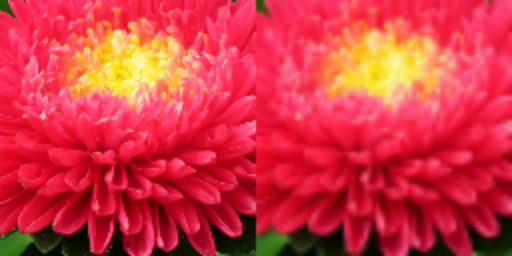

In [3]:
from IPython.display import HTML
from IPython.display import display as ip_display
from PIL import Image as Image


def display_tensor_images(named_images: dict[str, torch.Tensor]) -> None:
    """Display a PyTorch image tensor.

    Args:
        named_images: list of tensors with dimensions (channels, height, width).
    """
    title_html = ''

    for image_name in named_images:
        title_html += f"""
        <div style="text-align: center; width: 256px; font-size: 2em;">
        {image_name}
        </div>"""

    ip_display(HTML(f"""<div style=" display: flex;">{title_html}</div>"""))
    image = torch.cat(list(named_images.values()), dim=2)
    image = torch.nn.functional.interpolate(
        image.unsqueeze(0),
        size=(256, 256 * len(named_images)),
        mode='bilinear',
    ).squeeze()

    np_array = image.detach().cpu().permute(1, 2, 0).numpy().copy()
    np_array_int = (np_array * 255).astype(np.uint8)
    ip_display(Image.fromarray(np_array_int))
    return


display_tensor_images(
    {'Original': flower_torch, 'Baseline': baseline_reconstruction}
)

In [4]:
import dataclasses as dataclasses
import os

from drytorch import Experiment


@dataclasses.dataclass(frozen=True)
class ArchitecturalSettings:
    """Architectural settings for a Resnet with three stages.

    Attributes:
        norm_flag: whether to use instance normalization.
        n_blocks_per_stage: number of convolutional blocks in the three stages.
        max_width: number of channels of the middle stage (half in the others).
    """

    norm_flag: bool = False
    n_blocks_per_stage: tuple[int, int, int] = (2, 2, 2)
    max_width: int = 32


@dataclasses.dataclass(frozen=True)
class TrainingSettings:
    """Training settings for the current experiment.

    Attributes:
        lr: learning rate.
        n_epochs: number of training epochs.
    """

    lr: float = 0.001
    n_epochs: int = int(os.getenv('EPOCHS', '30'))


@dataclasses.dataclass(frozen=True)
class AllSettings:
    """General settings for the current experiment.

    Attributes:
        architecture: number of training epochs.
        train: how many samples in each mini-batch
    """

    architecture = ArchitecturalSettings()
    train = TrainingSettings()


class UpsamplingExperiment(Experiment[AllSettings]):
    """Class for upsampling experiments."""

    pass

In [5]:
import pathlib


settings = AllSettings()
experiment = UpsamplingExperiment(
    settings, name='Getting Started', par_dir=pathlib.Path('experiments')
)

In [6]:
from drytorch.trackers.csv import CSVDumper


experiment.trackers.subscribe(CSVDumper())

In [7]:
run = experiment.create_run()
run.start()

In [8]:
from typing import NamedTuple

import torch


class Inputs(NamedTuple):
    """Structured input.

    Deep priors do not use any input, so this class is empty
    """


class TrainingTargets(NamedTuple):
    """Structured target for training.

    Attributes:
        flower_downsampled: flower downsampled 2 to 1.
    """

    flower_downsampled: torch.Tensor


class TestTargets(NamedTuple):
    """Structured target for testing.

    Attributes:
        flower_original: the original flower array.
    """

    flower_original: torch.Tensor


@dataclasses.dataclass
class Outputs:
    """Structured target.

    Attributes:
        flower_reconstructed: reconstructed array of the flower image.
    """

    flower_reconstructed: torch.Tensor

In [9]:
import torch

from torch.utils import data


class TestDataset(data.Dataset[tuple[Inputs, TestTargets]]):
    """This dataset evaluates the reconstruction of the image.

    Attributes:
        target_image: the image to reconstruct
    """

    def __init__(self, target_image: torch.Tensor) -> None:
        """Constructor.

        Args:
            target_image: the image to reconstruct
        """
        super().__init__()
        self.target_image = target_image

    def __len__(self) -> int:
        """Number of samples to test."""
        return 1

    def __getitem__(self, _) -> tuple[Inputs, TestTargets]:
        """Method to overwrite to define the batch.

        Returns:
            Tuple with Inputs and Targets instances.
        """
        inputs = Inputs()
        targets = TestTargets(flower_original=self.target_image)
        return inputs, targets


class TrainingDataset(data.Dataset[tuple[Inputs, TrainingTargets]]):
    """This dataset trains the network to reconstruct the image.

    Attributes:
        downsampled_image: the image to upsample.
    """

    def __init__(self, downsampled_image: torch.Tensor) -> None:
        """Constructor.

        Args:
            downsampled_image: the image to upsample.
        """
        super().__init__()
        self.downsampled_image = downsampled_image

    def __len__(self) -> int:
        """Number of iterations per epoch."""
        return 32

    def __getitem__(self, _) -> tuple[Inputs, TrainingTargets]:
        """Method to overwrite to define the batch.

        Returns:
            tuple with Inputs and Targets instances.
        """
        inputs = Inputs()
        targets: TrainingTargets = TrainingTargets(
            flower_downsampled=self.downsampled_image
        )
        return inputs, targets


training_dataset = TrainingDataset(flower_torch_downsampled)
test_dataset = TestDataset(flower_torch)

In [10]:
from torch import nn


class ResNetBlock(nn.Module):
    """The fundamental residual block for ResNet."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """Initiates two convolution and the skip connection."""
        super().__init__()
        cfg_arc = UpsamplingExperiment.get_config().architecture
        norm_flag = cfg_arc.norm_flag
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),
            nn.LayerNorm(out_channels) if norm_flag else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels) if norm_flag else nn.Identity(),
        )

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    bias=False,
                ),
                nn.LayerNorm(out_channels) if norm_flag else nn.Identity(),
            )
        self.final_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Passes the input through the net, adding the residual connection."""
        out = self.net(x) + self.shortcut(x)
        out = self.final_activation(out)
        return out


class ResNetStage(nn.Sequential):
    """A single stage of the ResNet architecture."""

    def __init__(
        self, in_channels: int, out_channels: int, num_blocks: int
    ) -> None:
        """Initializes a stage with the required number of blocks."""
        layers: list[nn.Module] = []
        current_channels = in_channels
        for _ in range(num_blocks):
            layers.append(ResNetBlock(current_channels, out_channels))
            current_channels = out_channels
        super().__init__(*layers)


class ResNet(nn.Sequential):
    """A ResNet model for image reconstruction."""

    def __init__(self) -> None:
        """Initializes the entire ResNet structure."""
        cfg_arc = UpsamplingExperiment.get_config().architecture
        norm_flag = cfg_arc.norm_flag
        max_width = cfg_arc.max_width
        num_blocks = cfg_arc.n_blocks_per_stage

        layers: list[nn.Module] = [
            nn.Conv2d(16, max_width // 2, kernel_size=3, padding=1, bias=False),
            nn.LayerNorm(max_width // 2) if norm_flag else nn.Identity(),
            nn.ReLU(inplace=True),
            ResNetStage(max_width // 2, max_width, num_blocks[0]),
            ResNetStage(max_width, max_width, num_blocks[1]),
            ResNetStage(max_width, max_width // 2, num_blocks[2]),
            nn.Conv2d(max_width // 2, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        ]
        super().__init__(*layers)


class DeepPriorNet(nn.Module):
    """A net with a fixed input parameter."""

    def __init__(self) -> None:
        """Instantiate the net and the fixed input."""
        super().__init__()
        self.fixed_input = torch.nn.Parameter(
            torch.randn(1, 16, TARGET_SIZE, TARGET_SIZE)
        )
        self.net = ResNet()

    def forward(self, _: Inputs) -> Outputs:
        """Call the net on the fixed input."""
        return Outputs(self.net(self.fixed_input))


network = DeepPriorNet()

In [11]:
def psnr(recon: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Compute Peak Signal-to-Noise Ratio between two images ([0, 1] range)."""
    mse = nn.functional.mse_loss(recon, target)

    if mse == 0:
        return torch.tensor(torch.inf)

    return -10 * torch.log10(mse)


def target_psnr(outputs: Outputs, targets: TestTargets) -> torch.Tensor:
    """Mean Square Error in the target space."""
    return psnr(outputs.flower_reconstructed, targets.flower_original)


def downsampled_mse(outputs: Outputs, targets: TrainingTargets) -> torch.Tensor:
    """Mean Square Error in the downsampled space."""
    reconstruction_downsampled = interpolate(
        outputs.flower_reconstructed, DOWNSAMPLED_SIZE
    )
    return nn.functional.mse_loss(
        reconstruction_downsampled, targets.flower_downsampled
    )


baseline_psnr = psnr(baseline_reconstruction, flower_torch).item()

if not np.isclose(baseline_psnr, 25.90, atol=1e-2):
    raise AssertionError('Baseline should value should be about 25.90.')

In [12]:
from drytorch import DataLoader, LearningSchema, Loss, Model, Trainer


cfg_train = UpsamplingExperiment.get_config().train
train_loader = DataLoader(training_dataset, batch_size=1)

model = Model(network, name='DeepPriorNet')
learning_schema = LearningSchema.adam(cfg_train.lr)
loss = Loss(downsampled_mse, 'MSE')
trainer = Trainer(
    model, loader=train_loader, loss=loss, learning_schema=learning_schema
)
trainer.train(cfg_train.n_epochs)

[2026-01-06 17:27:27] - Training DeepPriorNet started.


Epoch::   0%|          | 0/30, 00:00<?

[2026-01-06 17:27:44] - Training ended.


In [13]:
from drytorch import Metric, Test


test_loader = DataLoader(test_dataset, batch_size=1)
metric = Metric(target_psnr, 'PSNR Target', False)
test = Test(model, loader=test_loader, metric=metric)
test(store_outputs=True)

[2026-01-06 17:27:44] - Testing DeepPriorNet started.


           Test:   0%|          | 0/1, 00:00<?

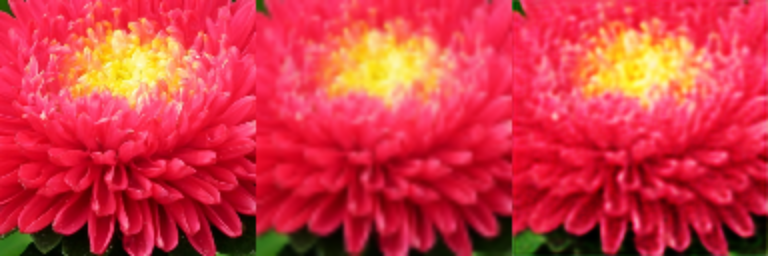

In [14]:
reconstructed = test.outputs_list[0].flower_reconstructed.squeeze()
display_tensor_images(
    {
        'Original': flower_torch,
        'Baseline': baseline_reconstruction,
        'Deep Prior': reconstructed,
    }
)

In [15]:
run.stop()